<a href="https://colab.research.google.com/github/newstage75/ML_study/blob/master/%E6%9C%80%E7%9F%ADPytorch/%EF%BC%99%E7%AB%A0_CIFAR10%E3%82%92%E4%BD%BF%E3%81%A3%E3%81%9F%E7%94%BB%E5%83%8F%E8%AA%8D%E8%AD%98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#9章 CIFAR10を使った画像認識

In [1]:
# 必要ライブラリの導入

!pip install japanize_matplotlib | tail -n 1
!pip install torchviz | tail -n 1
!pip install torchinfo | tail -n 1

In [2]:
# 必要ライブラリのインポート

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
from IPython.display import display

In [3]:
# torch関連ライブラリのインポート

import torch
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary
from torchviz import make_dot
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

In [4]:
# warning表示off
import warnings
warnings.simplefilter('ignore')

# デフォルトフォントサイズ変更
plt.rcParams['font.size'] = 14

# デフォルトグラフサイズ変更
plt.rcParams['figure.figsize'] = (6,6)

# デフォルトで方眼表示ON
plt.rcParams['axes.grid'] = True

# numpyの表示桁数設定
np.set_printoptions(suppress=True, precision=5)

In [5]:
# GPUチェック
# デバイスの割り当て

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


###CNN処理概要

In [6]:
data_root = './data'

#サンプルの手書き数字データを取得
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_set = datasets.MNIST(
    root = data_root, train = True,
    download = True, transform = transform
)

image, label = train_set[0]
image = image.view(1,1,28,28)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [7]:
#対角線上にのみ重みを持つ特殊な畳み込み関数を作る
conv1 = nn.Conv2d(1, 1, 3)

#biasを0に
nn.init.constant_(conv1.bias, 0.0)

#weightを特殊な値に
w1_np = np.array([[0,0,1],[0,1,0],[1,0,0]])
w1 = torch.tensor(w1_np).float()
w1 = w1.view(1, 1, 3, 3)
conv1.weight.data = w1

In [8]:
#手書き数字の3階畳み込み処理を行う
image, label = train_set[0]
image = image.view(1,1,28,28)
w1 = conv1(image)
w2 = conv1(w1)
w3 = conv1(w2)
images = [image, w1, w2, w3]

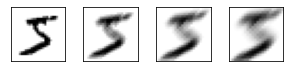

In [9]:
#結果の画像表示
plt.figure(figsize=(5, 1))
for i in range(4):
  #カーネルで2pixelずつ減っていくので補正。
  size = 28 -i*2
  #１行4列で、i+1の順番で表示
  ax = plt.subplot(1, 4,i+1)
  img = images[i].data.numpy()
  plt.imshow(img.reshape(size, size), cmap='gray_r')
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

In [11]:
#PyTorchでのCNN実装

#CNN前半部分　レイヤー関数の定義
conv1 = nn.Conv2d(3, 32, 3)
relu = nn.ReLU(inplace=True)
conv2 = nn.Conv2d(32, 32, 3)
maxpool = nn.MaxPool2d((2,2))

In [13]:
#conv1の確認
print(conv1)
#conv1の内部変数のshape確認
print(conv1.weight.shape)
print(conv1.bias.shape)

#conv2の確認
print(conv2)
#conv2の内部変数のshape確認
print(conv2.weight.shape)
print(conv2.bias.shape)

Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
torch.Size([32, 3, 3, 3])
torch.Size([32])
Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
torch.Size([32, 32, 3, 3])
torch.Size([32])


In [14]:
#conv1のweight[0]とは、出力チャネル0用の重み
w = conv1.weight[0]

#weight[0]のshapeと値を確認
print(w.shape)
print(w.data.numpy())

torch.Size([3, 3, 3])
[[[ 0.09003 -0.05258  0.02023]
  [ 0.10792 -0.10102 -0.02423]
  [ 0.16591 -0.16059 -0.07766]]

 [[ 0.06153  0.15401 -0.18717]
  [ 0.13045  0.13079  0.14798]
  [ 0.13019 -0.0039   0.16411]]

 [[ 0.11825 -0.08495  0.09181]
  [ 0.09628  0.06952  0.10598]
  [-0.00688  0.12516 -0.01066]]]


In [15]:
#ダミーで入力と同じサイズのTensorを生成
inputs = torch.randn(100, 3, 32, 32)
print(inputs.shape)

torch.Size([100, 3, 32, 32])


In [16]:
#CNNの前半部分をシミュレーションする
x1 = conv1(inputs)
x2 = relu(x1)
x3 = conv2(x2)
x4 = relu(x3)
x5 = maxpool(x4)

In [17]:
print(inputs.shape)
print(x1.shape)
print(x2.shape)
print(x3.shape)
print(x4.shape)
print(x5.shape)

torch.Size([100, 3, 32, 32])
torch.Size([100, 32, 30, 30])
torch.Size([100, 32, 30, 30])
torch.Size([100, 32, 28, 28])
torch.Size([100, 32, 28, 28])
torch.Size([100, 32, 14, 14])


In [18]:
#nn.Sequential
#関数定義
features = nn.Sequential(
    conv1,
    relu,
    conv2,
    relu,
    maxpool
)

In [19]:
#動作テスト
outputs = features(inputs)

#結果確認
print(outputs.shape)

torch.Size([100, 32, 14, 14])


In [20]:
#nn.Flatten(１階テンソルへ変換)
flatten = nn.Flatten()

#動作テスト
outputs2 = flatten(outputs)

#結果確認
print(outputs.shape)
print(outputs2.shape)

torch.Size([100, 32, 14, 14])
torch.Size([100, 6272])


#### １階テンソル化した後は、ニューラルネットワークと全く同じ。

###共通関数の定義

##eval_loss損失計算用

損失lossを計算すると、例えば、その変数を使って、損失の計算グラフを可視化できる。

引数として、loader(データローダー), device, net(モデルインスタンス), criterion(損失関数をとる)

In [21]:
#損失計算用
def eval_loss(loader, device, net, criterion):
  #データローダーから最初の1セットを取得する
  for images, labels in loader:
    break

  #デバイスの割り当て
  inputs = images.to(device)
  labels = labels.to(device)

  #予測計算
  outputs = net(inputs)

  #損失計算
  loss = criterion(outputs, labels)

  return loss

## fit学習用

今まで「繰り返し計算」と読んでいた部分を関数呼び出しでまとめて行うことが目的。

引数は８つ
*   net:学習対象のモデルインスタンス
*   optimizer:最適化関数のインスタンス
*   criterion:損失関数のインスタンス
*   num_epochs:繰り返し数
*   train_loader: 訓練用のデータローダー
*   test_loader: 検証用のデータローダー
*   device: GPU or CPU
*   history: これまでのhistory

戻り値はhistoryで7章までの実習のhisotoryと同様に、

繰り返し回数、訓練損失、訓練精度、検証損失、損失精度

の二次元配列をNumPy形式で返します。



In [39]:
#学習用関数
def fit(net, optimizer, criterion, num_epochs, train_loader, test_loader, device, history):

  #tqdmライブラリのインポート
  from tqdm.notebook import tqdm
  
  base_epochs = len(history)

  for epoch in range(base_epochs, num_epochs+base_epochs):
    train_loss = 0
    train_acc = 0
    val_loss =0
    val_acc = 0

    #訓練フェーズ
    net.train()
    count = 0

    for inputs, labels in tqdm(train_loader):
      count += len(labels)
      inputs = inputs.to(device)
      labels = labels.to(device)

      #勾配の初期化
      optimizer.zero_grad()

      #予測計算
      outputs = net(inputs)

      #損失計算
      loss = criterion(outputs, labels)
      train_loss += loss.item()

      #勾配計算
      loss.backward()

      #パラメータ修正
      optimizer.step()

      #予測値算出
      predicted = torch.max(outputs, 1)[1]

      #正解件数算出
      train_acc += (predicted == labels).sum().item()

      #損失と精度の計算
      avg_train_loss = train_loss / count
      avg_train_acc = train_acc / count

    #予測フェーズ
    net.eval()
    count = 0

    for inputs, labels in test_loader:
      count += len(labels)
      inputs = inputs.to(device)
      labels = labels.to(device)

      #予測計算
      outputs = net(inputs)

      #損失計算
      loss = criterion(outputs, labels)
      val_loss += loss.item()

      #予測値算出
      predicted = torch.max(outputs, 1)[1]

      #正解件数算出
      val_acc += (predicted == labels).sum().item()

      #損失と精度の計算
      avg_val_loss = val_loss / count
      avg_val_acc = val_acc / count

    print (f'Epoch [{(epoch+1)}/{num_epochs+base_epochs}], loss: {avg_train_loss:.5f} acc: {avg_train_acc:.5f} val_loss: {avg_val_loss:.5f}, val_acc: {avg_val_acc:.5f}')
    item = np.array([epoch+1, avg_train_loss, avg_train_acc, avg_val_loss, avg_val_acc])
    history = np.vstack((history, item))
  return history

##eval_history学習ログ解析用

In [23]:
# 学習ログ解析

def evaluate_history(history):
    #損失と精度の確認
    print(f'初期状態: 損失: {history[0,3]:.5f} 精度: {history[0,4]:.5f}') 
    print(f'最終状態: 損失: {history[-1,3]:.5f} 精度: {history[-1,4]:.5f}' )

    num_epochs = len(history)
    unit = num_epochs / 10

    # 学習曲線の表示 (損失)
    plt.figure(figsize=(9,8))
    plt.plot(history[:,0], history[:,1], 'b', label='訓練')
    plt.plot(history[:,0], history[:,3], 'k', label='検証')
    plt.xticks(np.arange(0,num_epochs+1, unit))
    plt.xlabel('繰り返し回数')
    plt.ylabel('損失')
    plt.title('学習曲線(損失)')
    plt.legend()
    plt.show()

    # 学習曲線の表示 (精度)
    plt.figure(figsize=(9,8))
    plt.plot(history[:,0], history[:,2], 'b', label='訓練')
    plt.plot(history[:,0], history[:,4], 'k', label='検証')
    plt.xticks(np.arange(0,num_epochs+1,unit))
    plt.xlabel('繰り返し回数')
    plt.ylabel('精度')
    plt.title('学習曲線(精度)')
    plt.legend()
    plt.show()

##show_images_labels イメージとラベルの表示

引数は４つ

loader:検証用データローダー

classes:正解データに対応するラベル値のリスト

net 予測対象の事前学習済みモデルインスタンス。Noneを渡すと正解データのみ表示できる。

device:予測計算に利用するデバイス。


In [24]:
# イメージとラベル表示
def show_images_labels(loader, classes, net, device):

    # データローダーから最初の1セットを取得する
    for images, labels in loader:
        break
    # 表示数は50個とバッチサイズのうち小さい方
    n_size = min(len(images), 50)

    if net is not None:
      # デバイスの割り当て
      inputs = images.to(device)
      labels = labels.to(device)

      # 予測計算
      outputs = net(inputs)
      predicted = torch.max(outputs,1)[1]
      #images = images.to('cpu')

    # 最初のn_size個の表示
    plt.figure(figsize=(20, 15))
    for i in range(n_size):
        ax = plt.subplot(5, 10, i + 1)
        label_name = classes[labels[i]]
        # netがNoneでない場合は、予測結果もタイトルに表示する
        if net is not None:
          predicted_name = classes[predicted[i]]
          # 正解かどうかで色分けをする
          if label_name == predicted_name:
            c = 'k'
          else:
            c = 'b'
          ax.set_title(label_name + ':' + predicted_name, c=c, fontsize=20)
        # netがNoneの場合は、正解ラベルのみ表示
        else:
          ax.set_title(label_name, fontsize=20)
        # TensorをNumPyに変換
        image_np = images[i].numpy().copy()
        # 軸の順番変更 (channel, row, column) -> (row, column, channel)
        img = np.transpose(image_np, (1, 2, 0))
        # 値の範囲を[-1, 1] -> [0, 1]に戻す
        img = (img + 1)/2
        # 結果表示
        plt.imshow(img)
        ax.set_axis_off()
    plt.show()

In [25]:
# PyTorch乱数固定用

def torch_seed(seed=123):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.use_deterministic_algorithms = True

###データ準備

In [26]:
# Transformsの定義

# transformer1 1階テンソル化

transform1 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5),
    transforms.Lambda(lambda x: x.view(-1)),
])

# transformer2 正規化のみ実施

# 検証データ用 : 正規化のみ実施
transform2 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5),
])

In [27]:

# データ取得用関数 Datasets

data_root = './data'

# 訓練データセット 1階テンソル版
train_set1 = datasets.CIFAR10(
    root = data_root, train = True, 
    download = True, transform = transform1)

# 検証データセット 1階テンソル版
test_set1 = datasets.CIFAR10(
    root = data_root, train = False, 
    download = True, transform = transform1)

# 訓練データセット 3階テンソル版
train_set2 = datasets.CIFAR10(
    root =  data_root, train = True, 
    download = True, transform = transform2)

# 検証データセット 3階テンソル版
test_set2 = datasets.CIFAR10(
    root = data_root, train = False, 
    download = True, transform = transform2)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


データセットの確認

In [28]:
image1, label1 = train_set1[0]
image2, label2 = train_set2[0]

print(image1.shape)
print(image2.shape)

torch.Size([3072])
torch.Size([3, 32, 32])


In [29]:
# データローダーの定義

# ミニバッチのサイズ指定
batch_size = 100

# 訓練用データローダー
# 訓練用なので、シャッフルをかける
train_loader1 = DataLoader(train_set1, batch_size=batch_size, shuffle=True)

# 検証用データローダー
# 検証時にシャッフルは不要
test_loader1 = DataLoader(test_set1,  batch_size=batch_size, shuffle=False) 

# 訓練用データローダー
# 訓練用なので、シャッフルをかける
train_loader2 = DataLoader(train_set2, batch_size=batch_size, shuffle=True)

# 検証用データローダー
# 検証時にシャッフルは不要
test_loader2 = DataLoader(test_set2,  batch_size=batch_size, shuffle=False) 

In [30]:
# train_loader1から1セット取得
for images1, labels1 in train_loader1:
    break

# train_loader2から1セット取得
for images2, labels2 in train_loader2:
    break

# それぞれのshape確認
print(images1.shape)
print(images2.shape)

torch.Size([100, 3072])
torch.Size([100, 3, 32, 32])


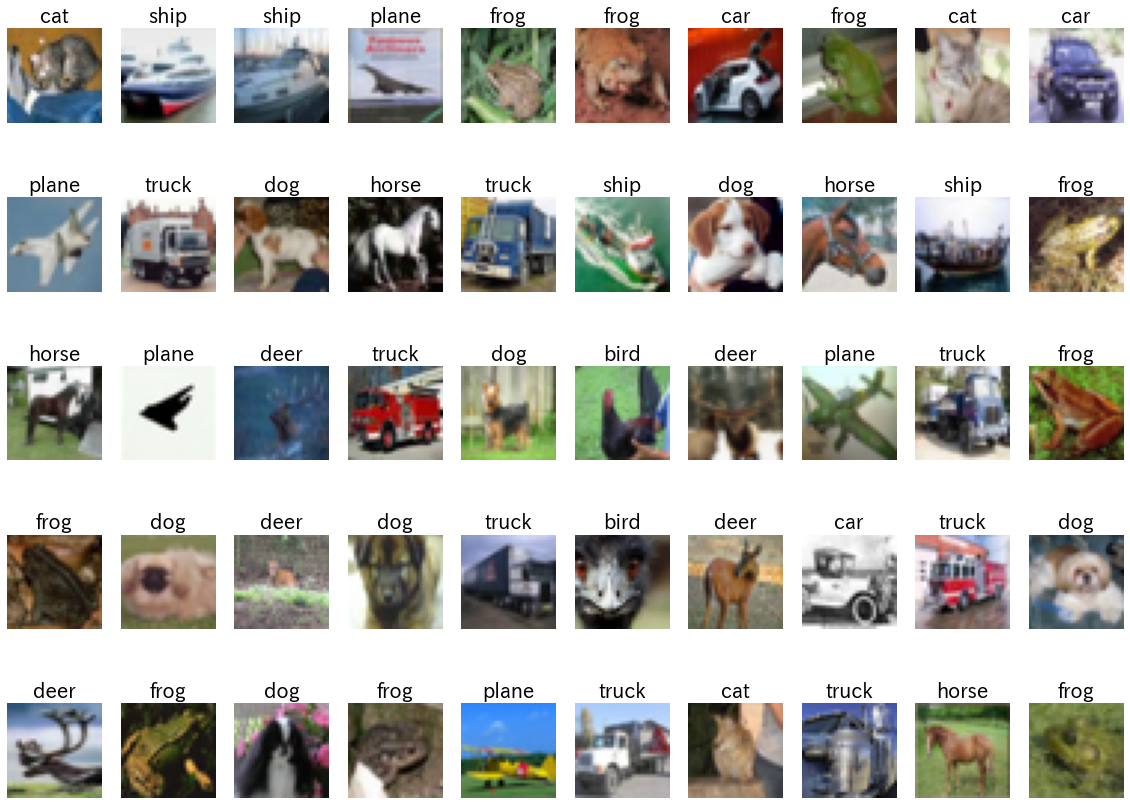

In [31]:
# 正解ラベル定義
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# 検証データ最初の50個の表示
show_images_labels(test_loader2, classes, None, None)

#9.7 モデル定義(全結合版)

In [32]:
# 入力次元数 今回は3*32*32=3072
n_input = image1.view(-1).shape[0]

# 出力次元数
# 分類先クラス数　今回は10になる
n_output = len(set(list(labels1.data.numpy())))

# 隠れ層のノード数
n_hidden = 128

# 結果確認
print(f'n_input: {n_input}  n_hidden: {n_hidden} n_output: {n_output}')

n_input: 3072  n_hidden: 128 n_output: 10


In [33]:
# モデルの定義
# 3072入力10出力1隠れ層のニューラルネットワークモデル

class Net(nn.Module):
    def __init__(self, n_input, n_output, n_hidden):
        super().__init__()

        # 隠れ層の定義 (隠れ層のノード数: n_hidden)
        self.l1 = nn.Linear(n_input, n_hidden)

        # 出力層の定義
        self.l2 = nn.Linear(n_hidden, n_output)

        # ReLU関数の定義
        self.relu = nn.ReLU(inplace=True)
   
    def forward(self, x):
        x1 = self.l1(x)
        x2 = self.relu(x1)
        x3 = self.l2(x2)
        return x3

In [34]:
# モデルインスタンス生成
net = Net(n_input, n_output, n_hidden).to(device)

# 損失関数： 交差エントロピー関数
criterion = nn.CrossEntropyLoss()

# 学習率
lr = 0.01

# 最適化関数: 勾配降下法
optimizer = torch.optim.SGD(net.parameters(), lr=lr)

In [35]:
# モデルの概要表示

print(net)

Net(
  (l1): Linear(in_features=3072, out_features=128, bias=True)
  (l2): Linear(in_features=128, out_features=10, bias=True)
  (relu): ReLU(inplace=True)
)


In [36]:
# モデルのサマリー表示

summary(net, (100,3072),depth=1)

Layer (type:depth-idx)                   Output Shape              Param #
Net                                      --                        --
├─Linear: 1-1                            [100, 128]                393,344
├─ReLU: 1-2                              [100, 128]                --
├─Linear: 1-3                            [100, 10]                 1,290
Total params: 394,634
Trainable params: 394,634
Non-trainable params: 0
Total mult-adds (M): 39.46
Input size (MB): 1.23
Forward/backward pass size (MB): 0.11
Params size (MB): 1.58
Estimated Total Size (MB): 2.92

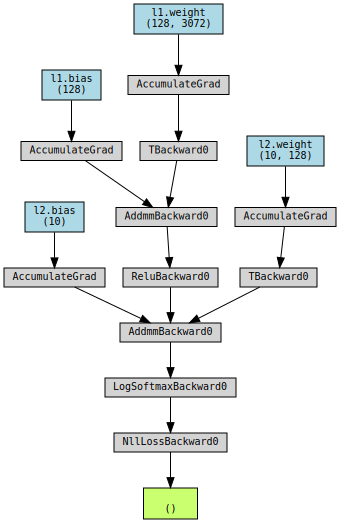

In [37]:
# 損失計算
loss = eval_loss(test_loader1, device, net, criterion)

# 損失の計算グラフ可視化
g = make_dot(loss, params=dict(net.named_parameters()))
display(g)

9.8 結果(全結合版)

In [40]:
# 乱数初期化
torch_seed()

# モデルインスタンス生成
net = Net(n_input, n_output, n_hidden).to(device)

# 損失関数： 交差エントロピー関数
criterion = nn.CrossEntropyLoss()

# 学習率
lr = 0.01

# 最適化関数: 勾配降下法
optimizer = optim.SGD(net.parameters(), lr=lr)

# 繰り返し回数
num_epochs = 50

# 評価結果記録用
history = np.zeros((0,5))

# 学習
history = fit(net, optimizer, criterion, num_epochs, train_loader1, test_loader1, device, history)


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [1/50], loss: 0.01950 acc: 0.32202 val_loss: 0.01794, val_acc: 0.37690


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [2/50], loss: 0.01738 acc: 0.39568 val_loss: 0.01684, val_acc: 0.41740


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [3/50], loss: 0.01655 acc: 0.42412 val_loss: 0.01622, val_acc: 0.43760


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [4/50], loss: 0.01602 acc: 0.44230 val_loss: 0.01583, val_acc: 0.45060


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [5/50], loss: 0.01563 acc: 0.45544 val_loss: 0.01553, val_acc: 0.46170


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [6/50], loss: 0.01532 acc: 0.46814 val_loss: 0.01530, val_acc: 0.46810


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [7/50], loss: 0.01505 acc: 0.47696 val_loss: 0.01512, val_acc: 0.47440


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [8/50], loss: 0.01480 acc: 0.48628 val_loss: 0.01493, val_acc: 0.47790


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [9/50], loss: 0.01457 acc: 0.49592 val_loss: 0.01480, val_acc: 0.48650


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [10/50], loss: 0.01435 acc: 0.50398 val_loss: 0.01463, val_acc: 0.48910


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [11/50], loss: 0.01413 acc: 0.51106 val_loss: 0.01450, val_acc: 0.49680


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [12/50], loss: 0.01394 acc: 0.52020 val_loss: 0.01437, val_acc: 0.50230


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [13/50], loss: 0.01375 acc: 0.52662 val_loss: 0.01425, val_acc: 0.50590


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [14/50], loss: 0.01357 acc: 0.53482 val_loss: 0.01423, val_acc: 0.50530


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [15/50], loss: 0.01341 acc: 0.53934 val_loss: 0.01408, val_acc: 0.51240


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [16/50], loss: 0.01324 acc: 0.54576 val_loss: 0.01402, val_acc: 0.51130


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [17/50], loss: 0.01307 acc: 0.55166 val_loss: 0.01391, val_acc: 0.51500


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [18/50], loss: 0.01293 acc: 0.55666 val_loss: 0.01388, val_acc: 0.51470


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [19/50], loss: 0.01279 acc: 0.56156 val_loss: 0.01379, val_acc: 0.52050


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [20/50], loss: 0.01264 acc: 0.56668 val_loss: 0.01381, val_acc: 0.51680


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [21/50], loss: 0.01251 acc: 0.57088 val_loss: 0.01372, val_acc: 0.51780


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [22/50], loss: 0.01238 acc: 0.57696 val_loss: 0.01368, val_acc: 0.52510


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [23/50], loss: 0.01225 acc: 0.58040 val_loss: 0.01363, val_acc: 0.52490


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [24/50], loss: 0.01213 acc: 0.58438 val_loss: 0.01356, val_acc: 0.52610


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [25/50], loss: 0.01200 acc: 0.59100 val_loss: 0.01352, val_acc: 0.52820


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [26/50], loss: 0.01190 acc: 0.59368 val_loss: 0.01351, val_acc: 0.52790


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [27/50], loss: 0.01178 acc: 0.59852 val_loss: 0.01350, val_acc: 0.52520


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [28/50], loss: 0.01167 acc: 0.60162 val_loss: 0.01343, val_acc: 0.52900


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [29/50], loss: 0.01156 acc: 0.60546 val_loss: 0.01342, val_acc: 0.52800


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [30/50], loss: 0.01145 acc: 0.60900 val_loss: 0.01346, val_acc: 0.52990


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [31/50], loss: 0.01135 acc: 0.61458 val_loss: 0.01340, val_acc: 0.53000


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [32/50], loss: 0.01124 acc: 0.61740 val_loss: 0.01338, val_acc: 0.52880


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [33/50], loss: 0.01115 acc: 0.62126 val_loss: 0.01339, val_acc: 0.53050


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [34/50], loss: 0.01105 acc: 0.62528 val_loss: 0.01342, val_acc: 0.52690


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [35/50], loss: 0.01096 acc: 0.62896 val_loss: 0.01341, val_acc: 0.52630


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [36/50], loss: 0.01086 acc: 0.63172 val_loss: 0.01334, val_acc: 0.53230


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [37/50], loss: 0.01077 acc: 0.63530 val_loss: 0.01340, val_acc: 0.52760


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [38/50], loss: 0.01068 acc: 0.63980 val_loss: 0.01336, val_acc: 0.53130


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [39/50], loss: 0.01059 acc: 0.64160 val_loss: 0.01342, val_acc: 0.53040


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [40/50], loss: 0.01051 acc: 0.64504 val_loss: 0.01349, val_acc: 0.52360


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [41/50], loss: 0.01041 acc: 0.64950 val_loss: 0.01341, val_acc: 0.52820


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [42/50], loss: 0.01033 acc: 0.65080 val_loss: 0.01347, val_acc: 0.52790


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [43/50], loss: 0.01025 acc: 0.65280 val_loss: 0.01347, val_acc: 0.52400


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [44/50], loss: 0.01016 acc: 0.65628 val_loss: 0.01346, val_acc: 0.52730


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [45/50], loss: 0.01007 acc: 0.65990 val_loss: 0.01345, val_acc: 0.52490


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [46/50], loss: 0.01000 acc: 0.66234 val_loss: 0.01345, val_acc: 0.52890


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [47/50], loss: 0.00993 acc: 0.66492 val_loss: 0.01349, val_acc: 0.52540


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [48/50], loss: 0.00984 acc: 0.66784 val_loss: 0.01352, val_acc: 0.52980


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [49/50], loss: 0.00977 acc: 0.67024 val_loss: 0.01364, val_acc: 0.51850


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [50/50], loss: 0.00970 acc: 0.67194 val_loss: 0.01354, val_acc: 0.53150


初期状態: 損失: 0.01794 精度: 0.37690
最終状態: 損失: 0.01354 精度: 0.53150


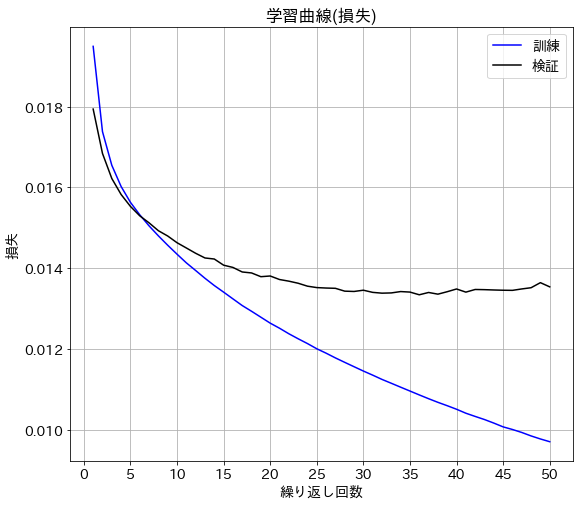

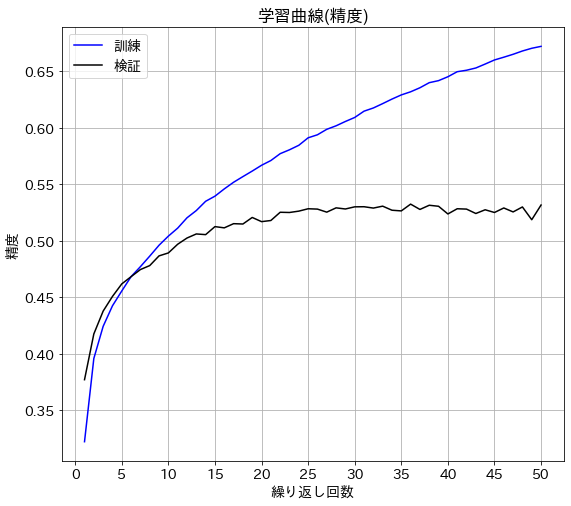

In [41]:
# 評価

evaluate_history(history)

CNN版

In [44]:
class CNN(nn.Module):
  def __init__(self, n_output, n_hidden):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 32, 3)
    self.conv2 = nn.Conv2d(32, 32, 3)
    self.relu = nn.ReLU(inplace=True)
    self.maxpool = nn.MaxPool2d((2,2))
    self.flatten = nn.Flatten()
    self.l1 = nn.Linear(6272, n_hidden)
    self.l2 = nn.Linear(n_hidden, n_output)

    self.features = nn.Sequential(
        self.conv1,
        self.relu,
        self.conv2,
        self.relu,
        self.maxpool)
    
    self.classifier = nn.Sequential(
       self.l1,
       self.relu,
       self.l2)

  def forward(self, x):
    x1 = self.features(x)
    x2 = self.flatten(x1)
    x3 = self.classifier(x2)
    return x3       

In [45]:
# モデルインスタンス生成
net = CNN(n_output, n_hidden).to(device)

# 損失関数： 交差エントロピー関数
criterion = nn.CrossEntropyLoss()

# 学習率
lr = 0.01

# 最適化関数: 勾配降下法
optimizer = torch.optim.SGD(net.parameters(), lr=lr)


In [46]:
# モデルの概要表示

print(net)

CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (l1): Linear(in_features=6272, out_features=128, bias=True)
  (l2): Linear(in_features=128, out_features=10, bias=True)
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=6272, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [47]:
# モデルのサマリー表示

summary(net,(100,3,32,32),depth=1)

Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      --                        --
├─Sequential: 1-1                        [100, 32, 14, 14]         10,144
├─Conv2d: 1-2                            [100, 32, 30, 30]         896
├─ReLU: 1-3                              [100, 32, 30, 30]         --
├─Conv2d: 1-4                            [100, 32, 28, 28]         9,248
├─ReLU: 1-5                              [100, 32, 28, 28]         --
├─MaxPool2d: 1-6                         [100, 32, 14, 14]         --
├─Flatten: 1-7                           [100, 6272]               --
├─Sequential: 1-8                        [100, 10]                 804,234
├─Linear: 1-9                            [100, 128]                802,944
├─ReLU: 1-10                             [100, 128]                --
├─Linear: 1-11                           [100, 10]                 1,290
Total params: 814,378
Trainable params: 814,378
Non-trainable pa

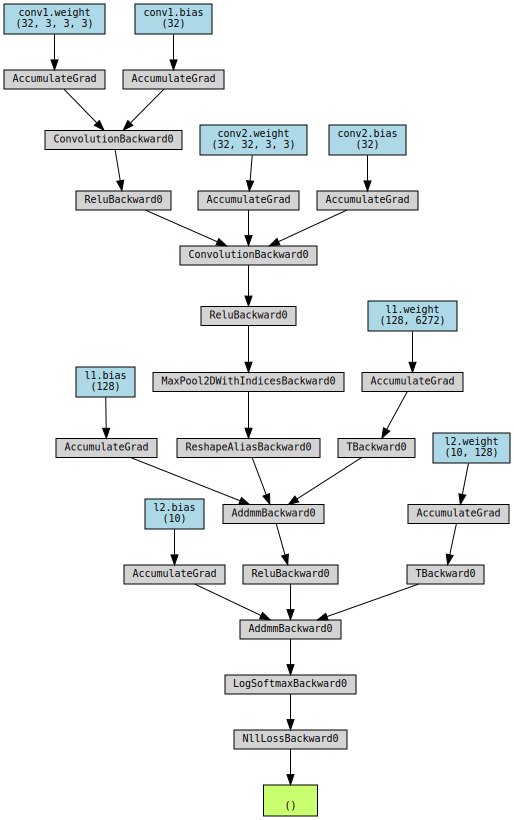

In [48]:
# 損失計算
loss = eval_loss(test_loader2, device, net, criterion)

# 損失の計算グラフ可視化
g = make_dot(loss, params=dict(net.named_parameters()))
display(g)

In [49]:
# 乱数初期化
torch_seed()

# モデルインスタンス生成
net = CNN(n_output, n_hidden).to(device)

# 損失関数： 交差エントロピー関数
criterion = nn.CrossEntropyLoss()

# 学習率
lr = 0.01

# 最適化関数: 勾配降下法
optimizer = optim.SGD(net.parameters(), lr=lr)

# 繰り返し回数
num_epochs = 50

# 評価結果記録用
history2 = np.zeros((0,5))

# 学習
history2 = fit(net, optimizer, criterion, num_epochs, train_loader2, test_loader2, device, history2)

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [1/50], loss: 0.02083 acc: 0.26090 val_loss: 0.01866, val_acc: 0.34630


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [2/50], loss: 0.01781 acc: 0.37264 val_loss: 0.01677, val_acc: 0.40870


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [3/50], loss: 0.01613 acc: 0.43046 val_loss: 0.01530, val_acc: 0.46070


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [4/50], loss: 0.01485 acc: 0.47334 val_loss: 0.01449, val_acc: 0.48890


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [5/50], loss: 0.01408 acc: 0.49968 val_loss: 0.01370, val_acc: 0.51280


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [6/50], loss: 0.01349 acc: 0.52134 val_loss: 0.01333, val_acc: 0.52640


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [7/50], loss: 0.01303 acc: 0.53770 val_loss: 0.01292, val_acc: 0.53900


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [8/50], loss: 0.01252 acc: 0.55486 val_loss: 0.01255, val_acc: 0.55250


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [9/50], loss: 0.01205 acc: 0.57456 val_loss: 0.01237, val_acc: 0.56160


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [10/50], loss: 0.01158 acc: 0.59116 val_loss: 0.01185, val_acc: 0.58160


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [11/50], loss: 0.01117 acc: 0.60832 val_loss: 0.01165, val_acc: 0.58880


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [12/50], loss: 0.01078 acc: 0.62370 val_loss: 0.01170, val_acc: 0.58350


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [13/50], loss: 0.01036 acc: 0.63596 val_loss: 0.01111, val_acc: 0.60480


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [14/50], loss: 0.00998 acc: 0.64972 val_loss: 0.01089, val_acc: 0.61190


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [15/50], loss: 0.00960 acc: 0.66396 val_loss: 0.01108, val_acc: 0.60400


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [16/50], loss: 0.00924 acc: 0.67672 val_loss: 0.01060, val_acc: 0.63080


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [17/50], loss: 0.00883 acc: 0.69240 val_loss: 0.01065, val_acc: 0.62520


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [18/50], loss: 0.00848 acc: 0.70286 val_loss: 0.01011, val_acc: 0.64600


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [19/50], loss: 0.00810 acc: 0.71868 val_loss: 0.01024, val_acc: 0.64220


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [20/50], loss: 0.00775 acc: 0.73062 val_loss: 0.01056, val_acc: 0.63170


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [21/50], loss: 0.00740 acc: 0.74088 val_loss: 0.01005, val_acc: 0.65270


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [22/50], loss: 0.00702 acc: 0.75708 val_loss: 0.01019, val_acc: 0.65380


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [23/50], loss: 0.00674 acc: 0.76674 val_loss: 0.00999, val_acc: 0.65710


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [24/50], loss: 0.00638 acc: 0.78048 val_loss: 0.01008, val_acc: 0.65630


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [25/50], loss: 0.00604 acc: 0.79248 val_loss: 0.01000, val_acc: 0.66890


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [26/50], loss: 0.00569 acc: 0.80616 val_loss: 0.01060, val_acc: 0.64540


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [27/50], loss: 0.00539 acc: 0.81634 val_loss: 0.01054, val_acc: 0.66330


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [28/50], loss: 0.00508 acc: 0.82664 val_loss: 0.01114, val_acc: 0.64490


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [29/50], loss: 0.00473 acc: 0.83934 val_loss: 0.01057, val_acc: 0.66630


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [30/50], loss: 0.00442 acc: 0.85320 val_loss: 0.01115, val_acc: 0.65820


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [31/50], loss: 0.00408 acc: 0.86248 val_loss: 0.01110, val_acc: 0.66430


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [32/50], loss: 0.00381 acc: 0.87338 val_loss: 0.01166, val_acc: 0.65240


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [33/50], loss: 0.00351 acc: 0.88530 val_loss: 0.01129, val_acc: 0.66300


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [34/50], loss: 0.00323 acc: 0.89350 val_loss: 0.01228, val_acc: 0.65340


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [35/50], loss: 0.00291 acc: 0.90688 val_loss: 0.01266, val_acc: 0.65570


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [36/50], loss: 0.00269 acc: 0.91364 val_loss: 0.01270, val_acc: 0.65250


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [37/50], loss: 0.00238 acc: 0.92646 val_loss: 0.01279, val_acc: 0.66390


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [38/50], loss: 0.00217 acc: 0.93348 val_loss: 0.01298, val_acc: 0.66910


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [39/50], loss: 0.00191 acc: 0.94286 val_loss: 0.01406, val_acc: 0.65570


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [40/50], loss: 0.00176 acc: 0.94968 val_loss: 0.01400, val_acc: 0.65980


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [41/50], loss: 0.00147 acc: 0.95940 val_loss: 0.01518, val_acc: 0.65320


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [42/50], loss: 0.00130 acc: 0.96556 val_loss: 0.01530, val_acc: 0.65820


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [43/50], loss: 0.00101 acc: 0.97748 val_loss: 0.01561, val_acc: 0.65880


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [44/50], loss: 0.00095 acc: 0.97812 val_loss: 0.01582, val_acc: 0.66280


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [45/50], loss: 0.00074 acc: 0.98584 val_loss: 0.01655, val_acc: 0.66320


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [46/50], loss: 0.00088 acc: 0.98418 val_loss: 0.01656, val_acc: 0.66060


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [47/50], loss: 0.00047 acc: 0.99410 val_loss: 0.01720, val_acc: 0.66190


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [48/50], loss: 0.00036 acc: 0.99648 val_loss: 0.01773, val_acc: 0.66110


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [49/50], loss: 0.00029 acc: 0.99774 val_loss: 0.01852, val_acc: 0.66330


  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [50/50], loss: 0.00024 acc: 0.99880 val_loss: 0.01877, val_acc: 0.66530


初期状態: 損失: 0.01866 精度: 0.34630
最終状態: 損失: 0.01877 精度: 0.66530


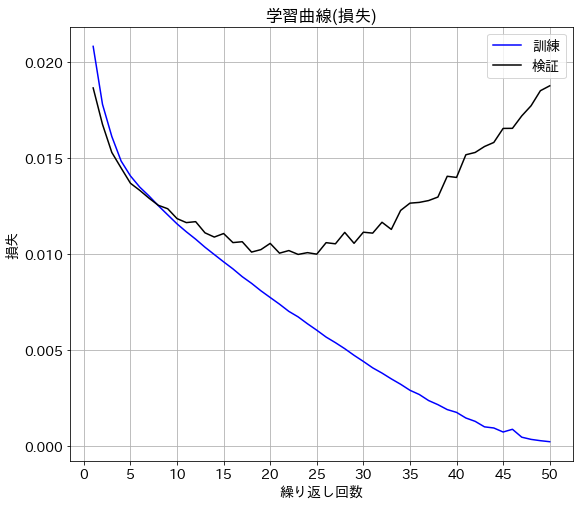

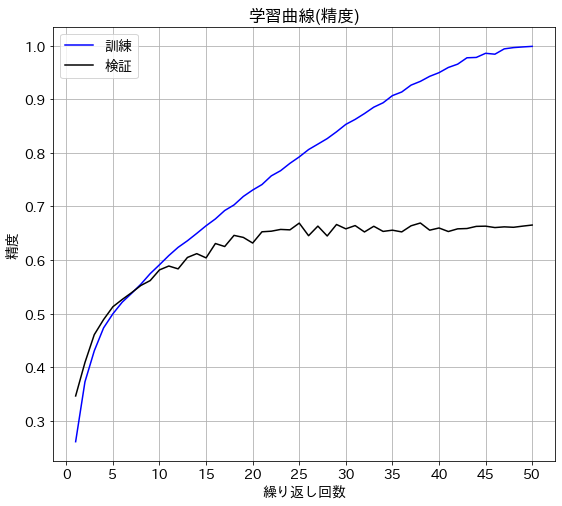

In [50]:
# 評価

evaluate_history(history2)

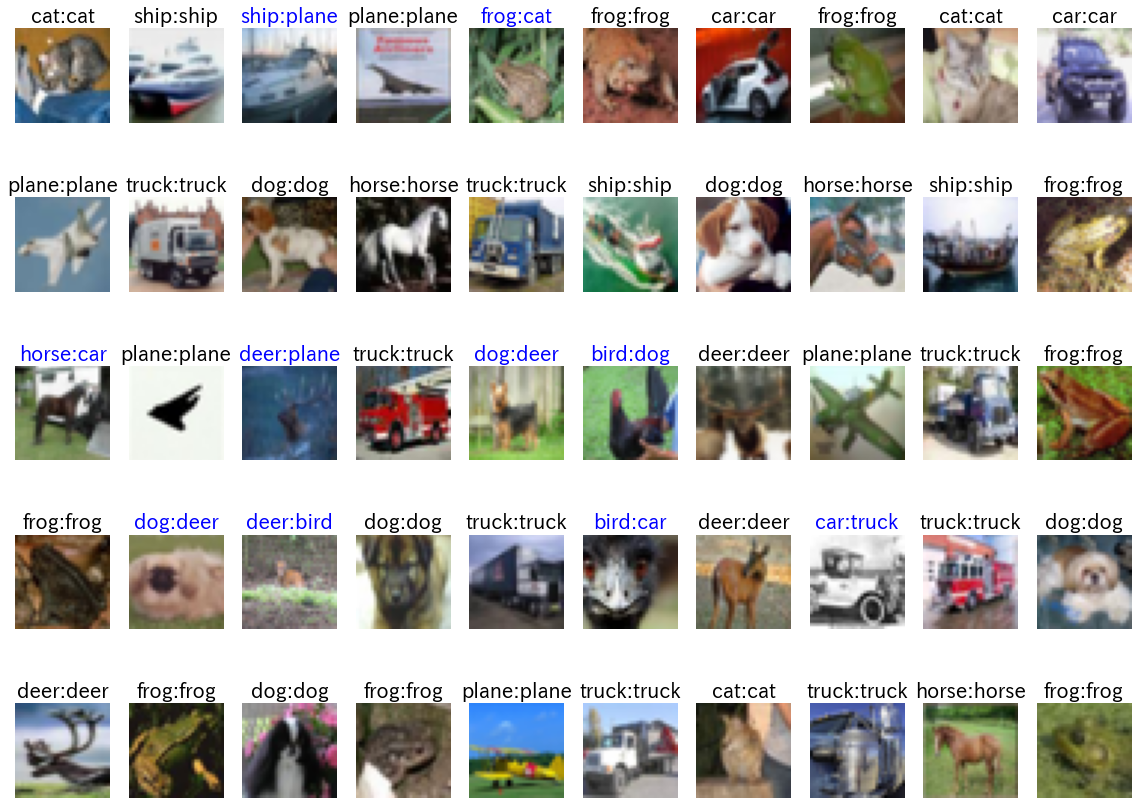

In [52]:
# 最初の50個の表示

show_images_labels(test_loader2, classes, net, device)